# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
%load_ext autoreload
%autoreload 2

## Import required packages

In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import re
from numpy import random
import random as rand

from dreaminsg_integrated_model.network_sim_models.interdependencies import *
import dreaminsg_integrated_model.network_sim_models.water.water_network_model as water
import dreaminsg_integrated_model.network_sim_models.power.power_system_model as power
import dreaminsg_integrated_model.network_sim_models.transportation.network as transpo
from dreaminsg_integrated_model.data.disruptive_scenarios.disrupt_generator import *
import dreaminsg_integrated_model.results.figures.plots as plots

import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings("ignore")

## Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [3]:
network_dir= 'in1'

MAIN_DIR = Path('..')
water_file = MAIN_DIR/'dreaminsg_integrated_model/data/networks/{}/water/Example_water.inp'.format(network_dir)
power_file = MAIN_DIR/'dreaminsg_integrated_model/data/networks/{}/power/Example_power.json'.format(network_dir)
transp_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/{}/transportation/'.format(network_dir)

#load water_network model
try:
    initial_sim_step = 60
    wn = water.load_water_network(water_file, initial_sim_step)
    total_base_water_demand = sum([wn.get_node(node).base_demand for node in wn.junction_name_list])
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)

#load power systems network
try:
    pn = power.load_power_network(power_file)
    power.run_power_simulation(pn)
    total_base_power_demand = pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum()
except UserWarning:
    print("Error: The power systems file does not exist. No such file or directory: ", power_file)

#load dynamic traffic assignment model
try:
    tn = transpo.Network(
        "{}/example_net.tntp".format(transp_folder), 
        "{}/example_trips.tntp".format(transp_folder),
        "{}/example_node.tntp".format(transp_folder))
    print("Transportation network successfully loaded from {}. Static traffic assignment method will be used to calculate travel times.".format(transp_folder))
    tn.userEquilibrium("FW", 400, 1e-4, tn.averageExcessCost)
except FileNotFoundError:
    print("Error: The transportation network folder does not exist. No such directory: ", transp_folder)
except AttributeError:
    print("Error: Some required network files not found.")

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in1\water\Example_water.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in1\power\Example_power.json

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in1\transportation. Static traffic assignment method will be used to calculate travel times.
Iteration 1: gap 0.000305: time 0.001030
Iteration 2: gap 0.000000: time 0.004021


## Create a Networkx graph of the integrated infrastructure network.

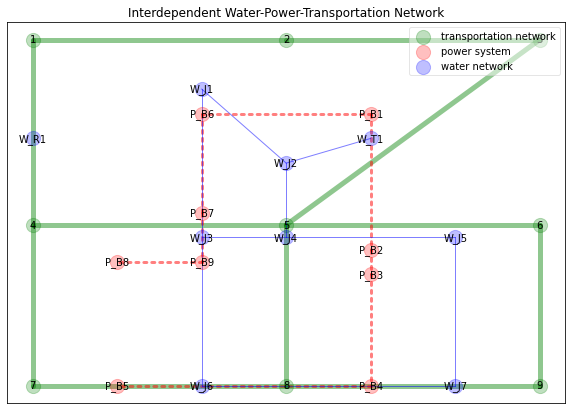

In [4]:
integrated_graph = plots.plot_integrated_network(pn, wn, tn)

## Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [5]:
dependency_table = DependencyTable()

#water - power dependencies stored to wp_table
dependency_table.add_pump_motor_coupling(water_id='W_WP1', power_id='P_MP1')
dependency_table.add_gen_reserv_coupling(water_id='W_R1', power_id='P_G3')
dependency_table.wp_table.head()

Reservoir Generator


,water_id,power_id,water_type,power_type
0,W_WP1,P_MP1,Pump,Motor
1,W_R1,P_G3,Reservoir,Generator


In [6]:
#transportation access dependencies saved to access_table
dependency_table.add_transpo_access(integrated_graph)
dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,4,power,Bus,125.00
1,P_B7,5,power,Bus,103.08
2,P_B5,7,power,Bus,100.00
3,P_B4,8,power,Bus,100.00
4,P_B6,2,power,Bus,180.28


## Simulation of interdependent effects using a test scenario
### (a) Scheduling infrastructure disruptions and optimal recovery actions.
Before we run the simulation, we need to specify the simulation parameters and recovery parameters.

In [7]:
#Setting recovery parameters
curr_loc_crew = 8 #transportation node
recovery_rate = 0.05 #unit per minute (hypothetical)

#Setting simulation parameters
sim_duration = 60*150 #150 minutes in total
sim_step = initial_sim_step

Now, we have to create a event table that has all the disruptions and recovery actions scheduled in it. For this first, we read the disruptive scenario file having information only about the disruptive events. The we add the disruptive events to the main **event_table**.

In [8]:
# creating test case dataframe
scenario_file = '../dreaminsg_integrated_model/data/disruptive_scenarios/test1/motor_failure.csv'
motor_failure = DisruptionAndRecovery(scenario_file, sim_duration, sim_step, curr_loc_crew)
motor_failure.disruptive_events

#change field name- not failure probability (damage extent)

,time_stamp,components,fail_perc
0,900,P_MP1,75
1,600,P_L1,50
2,1800,P_LO1,25


In [9]:
motor_failure.event_table.head()

,time_stamp,P_MP1,P_L1,P_LO1
0,0,100,100,100
1,60,100,100,100
2,120,100,100,100
3,180,100,100,100
4,240,100,100,100


Now, we identify the optimized recovery strategy (order of restoration/repair) and schedule the recovery actions in the **event_table**. The travel time for the repair crew from current location to the next location is computed using the transportation network model. 

In [10]:
#Simulating repair curves
repair_order =  motor_failure.optimze_recovery_strategy() #Felix' model will be embedded in this method.
print("The optimised repair strategy is to schedule repair of failed components in the following order: {}\n".format(repair_order))

if len(repair_order) > 0:
    for index, node in enumerate(repair_order):
        origin_node = node
        compon_infra, compon_notation, compon_code, compon_full = interdependencies.get_compon_details(origin_node)

        if compon_infra == "power":
            connected_bus = find_connected_power_node(origin_node, pn)
            nearest_node, near_dist = get_nearest_node(integrated_graph, connected_bus, "transpo_node")
            #print("The nearest node to {} is {} at a distance of {}m.".format(origin_node, nearest_node, near_dist))
        elif compon_infra == "water":
            connected_node = find_connected_water_node(origin_node, wn)
            nearest_node, near_dist = get_nearest_node(integrated_graph, connected_node, "transpo_node")

        travel_time = int(round(tn.calculateShortestTravelTime(motor_failure.curr_loc_crew, nearest_node), 0))
        print("The crew is at {} at t = {} minutes. It takes {} minutes to reach nearest node {}, the nearest transportation node from {}.".format(
            motor_failure.curr_loc_crew, motor_failure.next_crew_trip_start/motor_failure.sim_step, travel_time, nearest_node, node))
        recovery_start = motor_failure.next_crew_trip_start + travel_time*60

        #Schedule the recovery action
        recovery_start = motor_failure.next_crew_trip_start + travel_time*60
        motor_failure.schedule_recovery(origin_node, recovery_start, recovery_rate)
        motor_failure.curr_loc_crew  = nearest_node
    print("All restoration actions are successfully scheduled.")
else:
    print("No repair action to schedule. All components functioning perfectly.")

The optimised repair strategy is to schedule repair of failed components in the following order: ['P_L1', 'P_MP1', 'P_LO1']

The crew is at 8 at t = 10.0 minutes. It takes 13 minutes to reach nearest node 2, the nearest transportation node from P_L1.
The repair action at P_L1 successfuly completed at time 40.0 minutes

The crew is at 2 at t = 40.0 minutes. It takes 12 minutes to reach nearest node 4, the nearest transportation node from P_MP1.
The repair action at P_MP1 successfuly completed at time 77.0 minutes

The crew is at 4 at t = 77.0 minutes. It takes 4 minutes to reach nearest node 7, the nearest transportation node from P_LO1.
The repair action at P_LO1 successfuly completed at time 90.0 minutes

All restoration actions are successfully scheduled.


### (b) Simulating the interdependent effects
Now, the integrated network simulation is run with operational parameters of disrupted components fetched from the **event_table**.

In [11]:
power_consump_tracker = []
water_consump_tracker = []
time_tracker = []

wn.reset_initial_values()

#simulating the netwokwide impacts
for index, row in motor_failure.event_table.iterrows():
    #Update the operational level of directly affected components
    motor_failure.update_directly_affected_components(pn, wn, index)
    #print(pn.res_motor)

    #run power systems model
    power.run_power_simulation(pn)
    #print(pn.motor.in_service)

    #set the pump power value based on motor power value
    wn, pn = dependency_table.update_dependencies(pn, wn) #issue with changing pump status value
    
    #run water distribution model and save current status
    wn_results = water.run_water_simulation(wn)

    #Fix the time until which the wntr model should run in this iteration
    wn.options.time.duration += sim_step
    print(wn_results.link['status'])

    #track results
    time_tracker.append(int(row['time_stamp']/sim_step))
    power_consump_tracker.append((pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum())/total_base_power_demand)
    water_consump_tracker.append(sum([wn.get_node(node).demand for node in wn.junction_name_list])/total_base_water_demand)
    #print(sum([wn.get_node(node).demand for node in wn.junction_name_list]))
    
    if index % 10 == 0:
        
        print("Simulation for time {} minutes completed successfully".format(index))

#W_P3      W_P4      W_P5     W_P6      W_P7      W_P8     W_P9 W_P10    W_P11     W_WP1
#W_J1      W_J2       W_J3       W_J4       W_J5       W_J6  W_J7       W_T1  W_R1

W_WP1 1
    W_P3  W_P4  W_P5  W_P6  W_P7  W_P8  W_P9  W_P10  W_P11  W_WP1
0      1     1     1     1     1     1     1      1      1      1
60     1     1     1     1     1     1     1      1      1      1
Simulation for time 0 minutes completed successfully
W_WP1 1
     W_P3  W_P4  W_P5  W_P6  W_P7  W_P8  W_P9  W_P10  W_P11  W_WP1
120     1     1     1     1     1     1     1      1      1      1
W_WP1 1
     W_P3  W_P4  W_P5  W_P6  W_P7  W_P8  W_P9  W_P10  W_P11  W_WP1
180     1     1     1     1     1     1     1      1      1      1
W_WP1 1
     W_P3  W_P4  W_P5  W_P6  W_P7  W_P8  W_P9  W_P10  W_P11  W_WP1
240     1     1     1     1     1     1     1      1      1      1
W_WP1 1
     W_P3  W_P4  W_P5  W_P6  W_P7  W_P8  W_P9  W_P10  W_P11  W_WP1
300     1     1     1     1     1     1     1      1      1      1
W_WP1 1
     W_P3  W_P4  W_P5  W_P6  W_P7  W_P8  W_P9  W_P10  W_P11  W_WP1
360     1     1     1     1     1     1     1      1      1      1
W_WP1 1
     W_P3  W_P4  W_P5  

### Plot the direct and interdependent effects

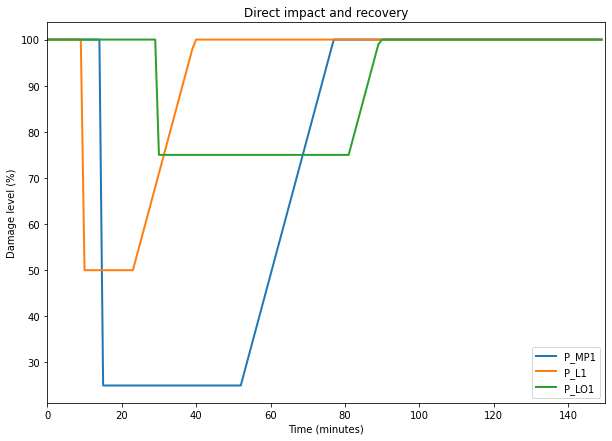

In [12]:
#Plotting repair curves
plots.plot_repair_curves(motor_failure)

c:\users\srijith\dropbox\intra-create seed grant\integrated model\dreaminsg_integrated_model\dreaminsg_integrated_model\results\figures\plots.py:244: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)  # row 1, column 2, count 1


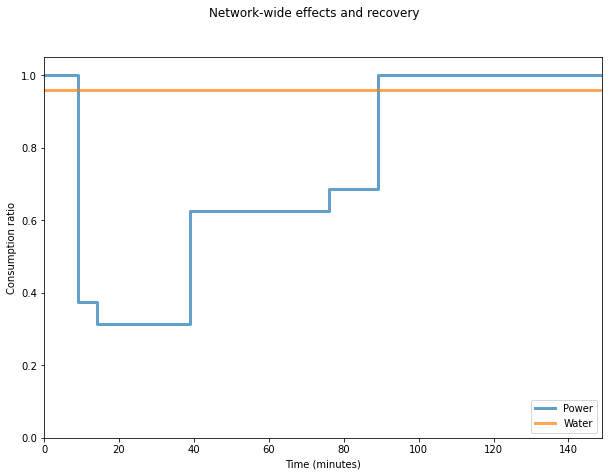

In [13]:
plots.plot_interdependent_effects(power_consump_tracker, water_consump_tracker, time_tracker)

### Nazli's comments

1. 